In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import timeit
import warnings
warnings.filterwarnings('ignore')

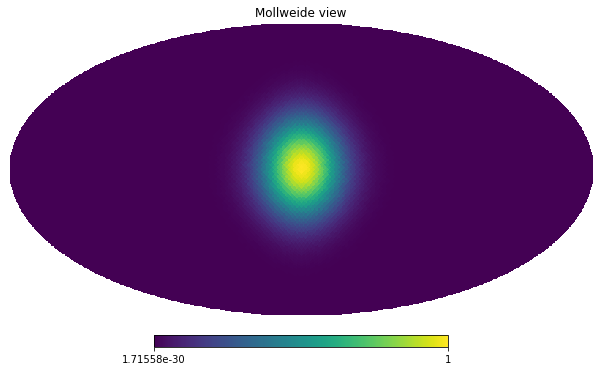

In [119]:
#returns a healpix map pixel array of a gaussian beam with 0 off-diagonal covariance pointing at (theta, phi)
def point_beam(theta, phi, beamthetastd=0.3, beamphistd=0.3, nres=400, nside=32, invert=True):
    inv = -1 if invert else 1
    thetagrid = np.hstack(np.repeat(np.linspace(0, np.pi, nres), nres).reshape(nres, nres))
    phigrid = np.hstack(np.repeat(np.linspace(-np.pi, np.pi, nres), nres).reshape(nres, nres).T)
    thetadist = thetagrid-theta
    phidist = np.minimum(np.minimum(np.abs(phigrid-inv*phi), np.abs(phigrid+2*np.pi-inv*phi)), \
                         np.abs(phigrid-2*np.pi-inv*phi)) #periodic boundary condition
    beam = 1/(2*np.pi*beamthetastd*beamphistd) * np.exp(-0.5*(thetadist**2/beamthetastd**2 + \
                                                              phidist**2/beamphistd**2))
    indices = hp.ang2pix(nside, thetagrid, phigrid, nest=False)
    hpxmap = np.zeros(hp.nside2npix(nside), dtype=np.float)
    hpxmap[indices] += beam
    return beam, indices, hpxmap/np.max(hpxmap) #return the beam in angular coords, the ang2pix indices, and the beam hpxmap
beam, indices, hpxmap = point_beam(np.pi/2, 0)
hp.mollview(hpxmap)

In [137]:
from scipy.ndimage import rotate
def rotate_beam(beam, indices, hpxmap, theta1, phi1, theta2, phi2, psi=0, nres=400, nside=32, onlybeam=False):
    thetas = np.linspace(0, np.pi, nres)
    phis = np.hstack(np.repeat(np.linspace(-np.pi, np.pi, nres), nres).reshape(nres, nres).T)
    theta1idx = np.argmin(np.abs(thetas-theta1))
    phi1idx = np.argmin(np.abs(phis-phi1))
    if psi != 0:
        centeredbeam = rotate_beam(beam, indices, hpxmap, theta1, phi1, np.pi/2, 0, psi=0, nres=nres, onlybeam=True)
        beamgrid = centeredbeam.reshape(nres, nres)
        beamgrid = rotate(beamgrid, angle=psi*180./np.pi, reshape=False) #from scipy.ndimage
        centeredbeam = beamgrid.flatten()
        beam = rotate_beam(centeredbeam, indices, hpxmap, np.pi/2, 0, theta1, phi1, psi=0, nres=nres, onlybeam=True)
    theta2idx = np.argmin(np.abs(thetas-theta2))
    phi2idx = np.argmin(np.abs(phis-phi2))
    beam = np.roll(beam, (theta2idx-theta1idx)*nres)
    beam = np.roll(beam, (-phi2idx+phi1idx))
    
    if onlybeam:
        return beam
    hpxmap.fill(0)
    hpxmap[indices] += beam
    return beam, hpxmap/np.max(hpxmap)

# beam, indices, hpxmap = point_beam(np.pi/2, np.pi/2, beamthetastd=0.2, beamphistd=0.1)
# hp.cartview(hpxmap)
# beam, hpxmap = rotate_beam(beam, indices, hpxmap, np.pi/2, np.pi/2, np.pi/2, np.pi/2, psi=np.pi/4)
# hp.cartview(hpxmap)

nsteps = 100
thetapath = np.linspace(np.pi/2, 0, nsteps)
phipath = np.linspace(-2*np.pi/3, 2*np.pi/3, nsteps)
psipath = np.linspace(0, 2*np.pi, nsteps)
beam, indices, hpxmap = point_beam(thetapath[0], phipath[0], beamthetastd=0.2, beamphistd=0.1)
for nstep in range(nsteps-1):
#     hp.mollview(hpxmap)
    beam, hpxmap = rotate_beam(beam, indices, hpxmap, thetapath[nstep], phipath[nstep],\
                               thetapath[nstep+1], phipath[nstep+1], psi=psipath[nstep+1]-psipath[nstep])

In [147]:
#ignore healpy rotations for now. We'll create the sky coverage matrix analytically for each pointing direction
def sky_coverage_old(lons, lats, coordsys='galactic', nres=400, nside=32, progress=0, display=False):
    skycov = np.zeros((lons.shape[0], hp.nside2npix(nside)))
    if coordsys in ['celestial', 'equatorial', 'c', 'C']: #conversion to galactic coords
        for i in range(lons.shape[0]):
            c = SkyCoord(lons[i], lats[i], frame='icrs', unit='deg')
            lons[i] = c.galactic.l.degree
            lats[i] = c.galactic.b.degree

    for i in range(lons.shape[0]):
        phi = (lons[i]%360-180)*np.pi/180
        theta = (90-lats[i])*np.pi/180
        beam, indices, beammap = point_beam(theta, phi, nres=nres, nside=nside, )
        if display:
            hp.mollview(beammap)
        skycov[i] = beammap
        if progress != 0 and i%progress==0:
            print(i)
    return skycov

def sky_coverage(lons, lats, psis, coordsys='galactic', beamthetastd=0.3, beamphistd=0.3, nres=400, nside=32, progress=0, display=False):
    skycov = np.zeros((lons.shape[0], hp.nside2npix(nside)))
    if coordsys in ['celestial', 'equatorial', 'c', 'C']: #conversion to galactic coords
        for i in range(lons.shape[0]):
            c = SkyCoord(lons[i], lats[i], frame='icrs', unit='deg')
            lons[i] = c.galactic.l.degree
            lats[i] = c.galactic.b.degree

    phis = (lons%360-180)*np.pi/180
    thetas = (90-lats)*np.pi/180
    beam, indices, beammap = point_beam(thetas[0], phis[0],\
                                        beamthetastd=beamthetastd, beamphistd=beamphistd, nres=nres, nside=nside)
    skycov[0] = beammap
    for i in range(1, lons.shape[0], 1):
        beam, beammap = rotate_beam(beam, indices, beammap, thetas[i-1], phis[i-1],\
                              thetas[i], phis[i], psi=psis[i], nres=nres, nside=nside)
        if display:
            hp.mollview(beammap)
        skycov[i] = beammap
        if progress != 0 and i%progress==0:
            print(i)
    return skycov

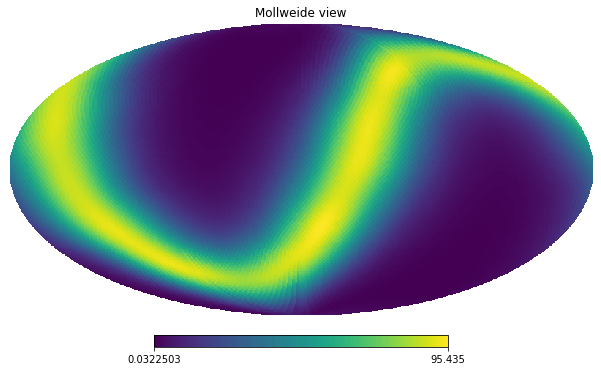

In [165]:
#say we want to give the path of the beam in equatorial coordinates:
nsteps=1000
ras = np.linspace(60, 420, nsteps) % 360
decs = np.linspace(0, 0, nsteps)
psis = np.linspace(0, 16*np.pi, nsteps) % 2*np.pi
skycov = sky_coverage(ras, decs, psis, beamthetastd=0.3, beamphistd=0.3, coordsys='c', nres=500, nside=32, display=False)
hp.mollview(np.sum(skycov, axis=0))

In [94]:
#time speedup from vectorization
t_vecs = []
t_unvecs = []
for nres in range(50, 1001, 50):
    nside = 16
    npix = hp.nside2npix(nside)
    theta = np.hstack(np.repeat(np.linspace(0, np.pi, nres), nres).reshape(nres, nres))
    phi = np.hstack(np.repeat(np.linspace(-np.pi, np.pi, nres), nres).reshape(nres, nres).T)
    beamthetastd = 0.075
    beamphistd = 0.1
    beammu = np.array([np.pi/2, 0])
    covar = np.matrix([[beamthetastd, 0], [0, beamphistd]])
    invcovar_thetatheta = np.linalg.inv(covar)[0, 0]
    invcovar_phiphi = np.linalg.inv(covar)[1, 1]
    beam = np.zeros(nres**2)

    tstart_unvec = timeit.default_timer()
    for i in range(nres**2):
        beam[i] = 1/(2*np.pi*beamthetastd*beamphistd) * np.exp(-0.5*((np.array([theta[i], phi[i]]-beammu).T)@np.linalg.inv(covar)@np.array([theta[i], phi[i]]-beammu)))
    tstop_unvec = timeit.default_timer()
    t_unvec = tstop_unvec - tstart_unvec
    t_unvecs.append(t_unvec)

    beam = np.zeros(nres**2)
    tstart_vec = timeit.default_timer()
    beam = 1/(2*np.pi*beamthetastd*beamphistd) * np.exp(-0.5*(invcovar_thetatheta*(theta-beammu[0])**2 + invcovar_phiphi*(phi-beammu[1])**2))
    tstop_vec = timeit.default_timer()
    t_vec = tstop_vec - tstart_vec
    t_vecs.append(t_vec)
    print(f'Unvectorized: {t_unvec} sec\tVectorized: {t_vec} sec\nSpeedup: {t_unvec/t_vec}x\n')

Unvectorized: 0.10023300000466406 sec	Vectorized: 7.049999840091914e-05 sec
Speedup: 1421.7447131652316x

Unvectorized: 0.3402804999932414 sec	Vectorized: 0.00012820000119972974 sec
Speedup: 2654.2940468705606x

Unvectorized: 0.7800967999937711 sec	Vectorized: 0.00031210000452119857 sec
Speedup: 2499.50909545977x

Unvectorized: 1.4589227999967989 sec	Vectorized: 0.0005056000081822276 sec
Speedup: 2885.527643170006x

Unvectorized: 2.3492216000013286 sec	Vectorized: 0.0014455999917117879 sec
Speedup: 1625.084126639714x

Unvectorized: 3.161332699994091 sec	Vectorized: 0.0010469999979250133 sec
Speedup: 3019.4199677739707x

Unvectorized: 4.083002899991698 sec	Vectorized: 0.0014996999962022528 sec
Speedup: 2722.5464495107294x

Unvectorized: 5.351688299997477 sec	Vectorized: 0.002014400000916794 sec
Speedup: 2656.715795056501x

Unvectorized: 6.889418699996895 sec	Vectorized: 0.0026326000079279765 sec
Speedup: 2616.963716192991x

Unvectorized: 8.793841499995324 sec	Vectorized: 0.0035320000024

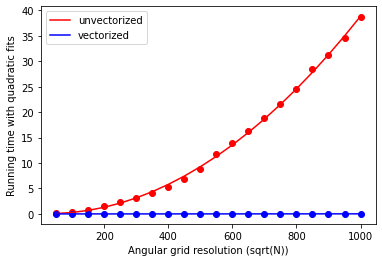

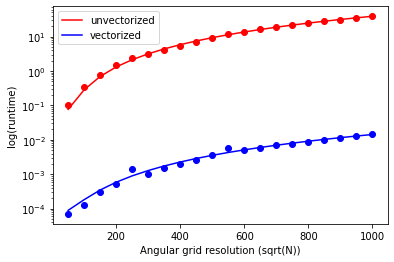

In [130]:
plt.figure(figsize=(6, 4))
plt.scatter(nress, t_unvecs, color='red')
nress = np.arange(50, 1001, 50)
fit1 = np.polyfit(nress, t_unvecs, 2)
plt.plot(nress, fit1[0]*nress**2+fit1[1]*nress+fit1[2], color='red', label='unvectorized')
plt.scatter(nress, t_vecs, color='blue')
fit2 = np.polyfit(nress, t_vecs, 2)
plt.plot(nress, fit2[0]*nress**2+fit2[1]*nress+fit2[2], color='blue', label='vectorized')
plt.xlabel('Angular grid resolution (sqrt(N))')
plt.ylabel('Running time with quadratic fits')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.yscale('log')
plt.scatter(nress, t_unvecs, color='red')
plt.scatter(nress, t_vecs, color='blue')
plt.plot(nress, fit1[0]*nress**2+fit1[1]*nress+fit1[2], color='red', label='unvectorized')
plt.plot(nress, fit2[0]*nress**2+fit2[1]*nress+fit2[2], color='blue', label='vectorized')
plt.xlabel('Angular grid resolution (sqrt(N))')
plt.ylabel('log(runtime)')
plt.legend()
plt.show()

In [126]:
#time speedup from rotation function
t_news = []
t_olds = []
for nsteps in range(10, 11, 50):
    nsteps = 100
    ls = np.linspace(0, 360, nsteps)
    bs = np.linspace(0, 0, nsteps)
    psis = np.linspace(0, 0, nsteps)

    tstart_old = timeit.default_timer()
    skycov_old = sky_coverage_old(ls, bs)
    tstop_old = timeit.default_timer()
    t_old = tstop_old - tstart_old
    t_olds.append(t_old)

    beam = np.zeros(nres**2)
    tstart_new = timeit.default_timer()
    skycov = sky_coverage(ls, bs, psis)
    tstop_new = timeit.default_timer()
    t_new = tstop_new - tstart_new
    t_news.append(t_new)
    print(f'Old: {t_old} sec\tNew: {t_new} sec\nSpeedup: {t_old/t_new}x\n')
hp.mollview(np.sum(skycov, axis=1))

Old: 1.0268704000045545 sec	New: 0.3142280000029132 sec
Speedup: 3.2679150171055236x



TypeError: bad number of pixels

In [123]:
def compute_B(skycov, lmax=15):
    alms = np.full((skycov.shape[0], int((lmax+2)*(lmax+1)/2.0)), 0.+0.j)
    for beamnumber in range(nsteps):
        alms[beamnumber] = hp.map2alm(skycov[beamnumber], lmax=lmax)
    return alms

def compute_corr(B, l=1, m=0, lmax=15):
    reals10, imags10 = get_alm(B, l, m, lmax)
    realcorrs = np.zeros(int((lmax+2)*(lmax+1)/2.0))
    imagcorrs = np.zeros(int((lmax+2)*(lmax+1)/2.0))
    for l in range(lmax):
        for m in range(l+1):
            realslm, imagslm = get_alm(B, l, m, lmax)
            realcorrs[hp.Alm.getidx(15, l, m)] = np.correlate(reals10, realslm)
            imagcorrs[hp.Alm.getidx(15, l, m)] = np.correlate(imags10, imagslm)
    return realcorrs, imagcorrs

def get_alm(B, l, m, lmax):
    idx = hp.Alm.getidx(lmax, l, m)
    real = np.real(B[:, idx])
    imag = np.imag(B[:, idx])
    return real, imag